In [1]:
# GPU USED FOR THIS NOTEBOOK: GeForce RTX 4070 (8GB of RAM)

In [2]:
!pip install timm

In [3]:
import torch
from torch import nn
import timm
from torchvision import models
from matplotlib import pyplot as plt
from typing import Callable
import numpy as np

%matplotlib inline

In [4]:
def vit_s_8():
    """ViT-S/8 is not a default torchvision model, so we provide it by timm"""
    # Accuracy approximation comes from
    # https://openreview.net/pdf?id=LtKcMgGOeLt
    # and DINO
    # https://arxiv.org/abs/2104.14294
    return timm.create_model('vit_small_patch8_224', pretrained=True)

# Model definitions
# Optional Q: These are uncalled functions. What do you think would happen
# if we called all of them once? Why didn't we do that?
model_defs = [
    vit_s_8,
    models.vit_b_32,
    models.vgg11,
    models.vgg11_bn,
    models.resnet18,
    models.densenet121,
    models.mobilenet_v3_small,
]

# Accuracies per model
model_accs = {
    'vit_s_8': 80., # Approximated
    'vit_b_32' : 75.912,
    'vgg11' : 69.02,
    'vgg11_bn' : 70.37,
    'resnet18' : 69.758,
    'densenet121' : 74.434,
    'mobilenet_v3_small' : 67.668,
}


def measure_runtime_per_forward(model:nn.Module, no_grad:bool, batch_size:int=8):
    """Measures the time for a single pass in milliseconds"""

    # Generate fake RGB input (224x224)
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    torch.manual_seed(42)
    inp = torch.rand((batch_size, 3, 224, 224), device=device)
    #######################
    # END OF YOUR CODE    #
    #######################

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()

    # Run the model
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    if no_grad:
        with torch.no_grad():
            out = model(inp)
            vram = torch.cuda.memory_allocated()
    else:
        out = model(inp)
        vram = torch.cuda.memory_allocated()
        
    #######################
    # END OF YOUR CODE    #
    #######################

    end.record()
    torch.cuda.synchronize()
    return start.elapsed_time(end), vram


def evaluate_model(model_def:Callable, no_grad:bool, batch_size:int=8, name:str='vit_s_8'):

    # Retreive initial memory allocation
    initial_vram = torch.cuda.memory_allocated()

    # Define model
    if name == 'vit_s_8':
        model = model_def().cuda().eval()
    else:
        model = model_def(weights='DEFAULT').cuda().eval()
    # Access name as: model.__name__

    # Parameters that need to be filled
    n_params = None
    times, vrams = [], []
    mean_time = None
    mean_vram = None

    #######################
    # PUT YOUR CODE HERE  #
    #######################

    # Step 1: Calculate the number of **trainable** parameters
    # Step 2: Warm up with a few passes
    # Step 3: Run N forward passes and save the runtime +
    #         the vram allocated by the model
    # Step 4: Take the mean, preferably with dropping possible outliers
    N = 100
    for n in range(N):
        time, vram = measure_runtime_per_forward(model, no_grad, batch_size)
        times.append(time)
        vrams.append(vram - initial_vram)

    times = np.array(times)
    vrams = np.array(vrams)
    
    mean_time = np.mean(times)
    std_time = np.std(times)
    outlier_mask = np.isclose(times, mean_time, atol=std_time*2)
    times = times[np.where(outlier_mask == True)[0]]
    mean_time = np.mean(times)
    std_time = np.std(times)
    
    mean_vram = np.mean(vrams)
    std_vram = np.std(vrams)
    outlier_mask = np.isclose(vrams, mean_vram, atol=std_vram*2)
    vrams = vrams[np.where(outlier_mask == True)[0]]
    mean_vram = np.mean(vrams)
    std_vram = np.std(vrams)
    
    n_params = np.sum([np.prod(param.size()) for param in model.parameters() if param.requires_grad])
    
    #######################
    # END OF YOUR CODE    #
    #######################

    # Clean up space for the model
    del model
    torch.cuda.empty_cache()

    return mean_time, mean_vram, n_params


Model vit_s_8
Number of parameters 21670272;  Mean inference time (batch=8) 67.25007648660679 ms;  Mean inference vram usage (batch=8) 109965312.0 bytes
Mean inference time for one frame 10.36210134294298 ms

Model vit_b_32
Number of parameters 88224232;  Mean inference time (batch=8) 11.95521006376847 ms;  Mean inference vram usage (batch=8) 358401536.0 bytes
Mean inference time for one frame 2.572853353288439 ms

Model vgg11
Number of parameters 132863336;  Mean inference time (batch=8) 14.990352120062317 ms;  Mean inference vram usage (batch=8) 536696320.0 bytes
Mean inference time for one frame 3.803783098856608 ms

Model vgg11_bn
Number of parameters 132868840;  Mean inference time (batch=8) 16.920977151522074 ms;  Mean inference vram usage (batch=8) 536745472.0 bytes
Mean inference time for one frame 3.9183466964297824 ms

Model resnet18
Number of parameters 11689512;  Mean inference time (batch=8) 3.5307684980257594 ms;  Mean inference vram usage (batch=8) 51710464.0 bytes
Mean 

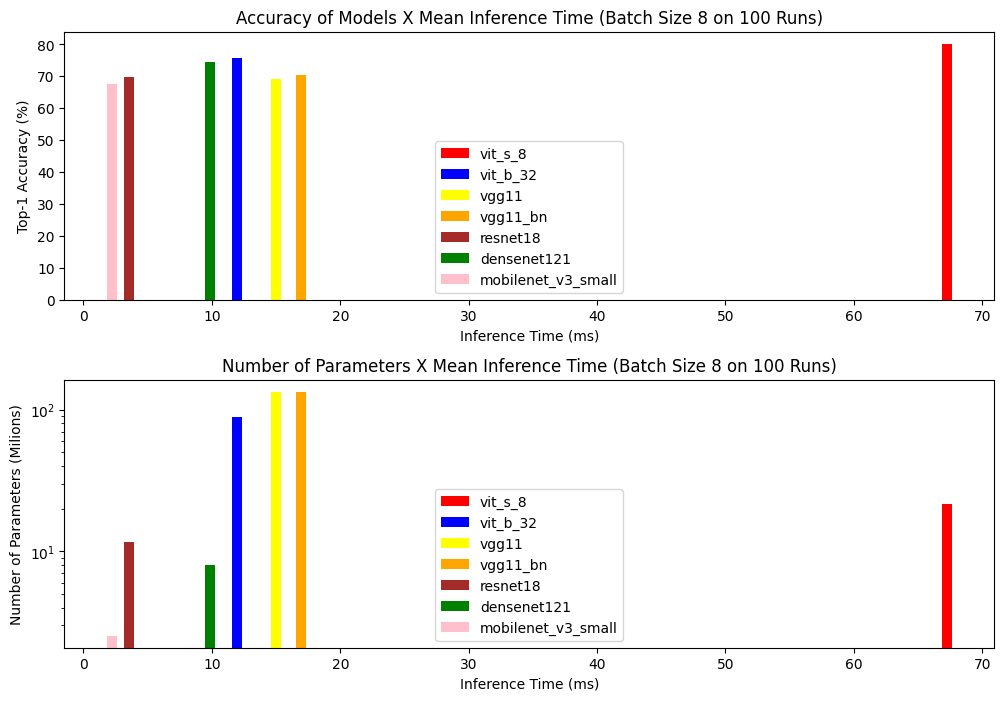

In [5]:
#######################
# PUT YOUR CODE HERE  #
#######################

# Make your plots here with matplotlib
#
# Example usage of the above functions:
# for model_def in model_defs:
#     name = model_def.__name__
#     time, vram, n_params = evaluate_model(model_def, no_grad=True)
#     print(name, time, vram, n_params)

names = []
mean_times = []
mean_vrams = []
n_parameters = []
mean_times_one_frame = [10.36210134294298, 2.572853353288439, 3.803783098856608, 3.9183466964297824,
                        1.0440640052159627, 6.012049780951606, 1.891395542356703]
for i, model_def in enumerate(model_defs):
    name = model_def.__name__
    mean_time, mean_vram, n_params = evaluate_model(model_def, no_grad=True, batch_size=8, name=name)
    print('Model {}'.format(name))
    print('Number of parameters {};  Mean inference time (batch=8) {} ms;  Mean inference vram usage (batch=8) {} bytes'.format(n_params,
                                                                                                                                mean_time,
                                                                                                                                mean_vram))
    print('Mean inference time for one frame {} ms\n'.format(mean_times_one_frame[i]))
    names.append(name)
    mean_times.append(mean_time)
    mean_vrams.append(mean_vram)
    n_parameters.append(n_params)

plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
colors = ['red', 'blue', 'yellow', 'orange', 'brown', 'green', 'pink']

plt.subplot(2, 1, 1)
plt.bar(mean_times, model_accs.values(), color=colors, label=names)
plt.title('Accuracy of Models X Mean Inference Time (Batch Size 8 on 100 Runs)')
plt.xlabel('Inference Time (ms)')
plt.ylabel('Top-1 Accuracy (%)')
plt.legend()

plt.subplot(2, 1, 2)
plt.bar(mean_times, np.array(n_parameters)/1e6, color=colors, label=names)
plt.title('Number of Parameters X Mean Inference Time (Batch Size 8 on 100 Runs)')
plt.xlabel('Inference Time (ms)')
plt.ylabel('Number of Parameters (Milions)')
plt.yscale('log')
plt.legend()

plt.show()
    
#######################
# END OF YOUR CODE    #
#######################

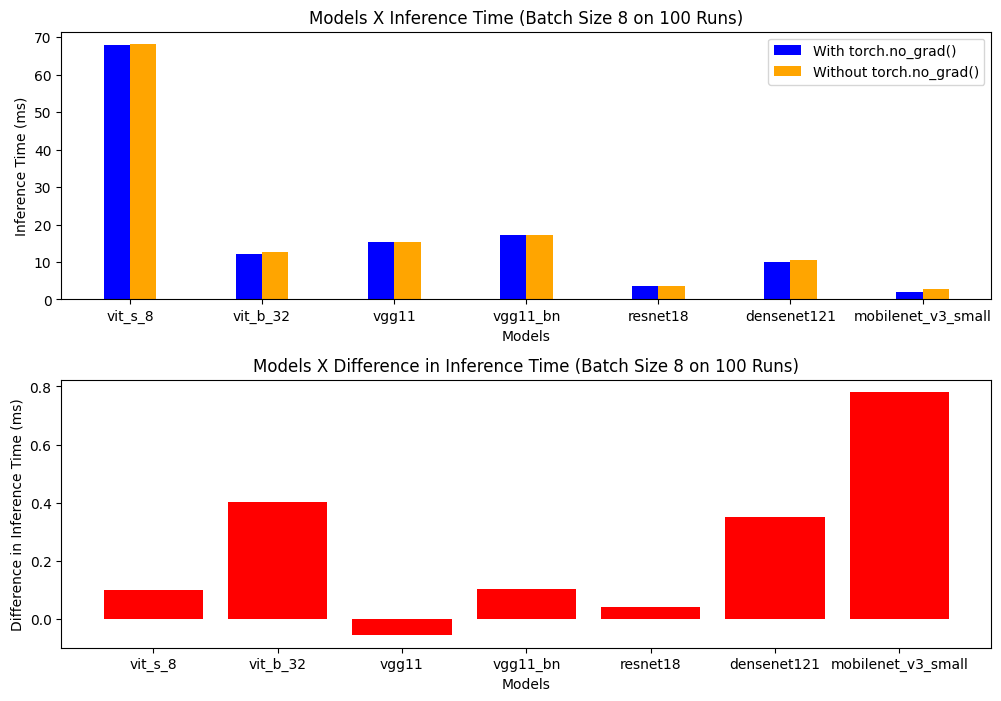

In [6]:
names = []
mean_times_with = []
mean_vrams_with = []
mean_times_without = []
mean_vrams_without = []
for i, model_def in enumerate(model_defs):
    name = model_def.__name__
    mean_time, mean_vram, _ = evaluate_model(model_def, no_grad=True, batch_size=8, name=name)
    names.append(name)
    
    mean_times_with.append(mean_time)
    mean_vrams_with.append(mean_vram)

    mean_time, mean_vram, _ = evaluate_model(model_def, no_grad=False, batch_size=8, name=name)

    mean_times_without.append(mean_time)
    mean_vrams_without.append(mean_vram)

plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

plt.subplot(2, 1, 1)
x = np.arange(7)
width = 0.2
plt.bar(x-width/2, mean_times_with, width, color='blue', label='With torch.no_grad()')
plt.bar(x+width/2, mean_times_without, width, color='orange', label='Without torch.no_grad()')
plt.xticks(x, names)
plt.title('Models X Inference Time (Batch Size 8 on 100 Runs)')
plt.xlabel('Models')
plt.ylabel('Inference Time (ms)')
plt.legend()

plt.subplot(2, 1, 2)
plt.bar(x, np.array(mean_times_without)-np.array(mean_times_with), color='red')
plt.xticks(x, names)
plt.title('Models X Difference in Inference Time (Batch Size 8 on 100 Runs)')
plt.xlabel('Models')
plt.ylabel('Difference in Inference Time (ms)')

plt.show()

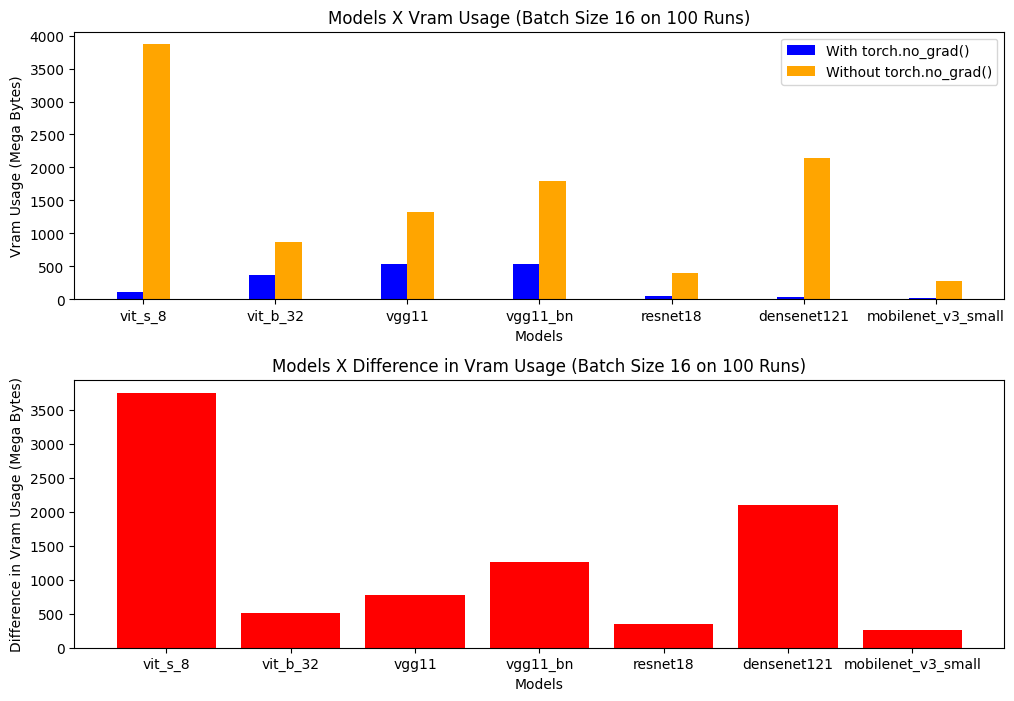

In [7]:
names = []
mean_times_with = []
mean_vrams_with = []
mean_times_without = []
mean_vrams_without = []
for i, model_def in enumerate(model_defs):
    name = model_def.__name__
    mean_time, mean_vram, _ = evaluate_model(model_def, no_grad=True, batch_size=16, name=name)
    names.append(name)
    
    mean_times_with.append(mean_time)
    mean_vrams_with.append(mean_vram)

    mean_time, mean_vram, _ = evaluate_model(model_def, no_grad=False, batch_size=16, name=name)

    mean_times_without.append(mean_time)
    mean_vrams_without.append(mean_vram)

plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

plt.subplot(2, 1, 1)
x = np.arange(7)
width = 0.2
plt.bar(x-width/2, np.array(mean_vrams_with)/1e6, width, color='blue', label='With torch.no_grad()')
plt.bar(x+width/2, np.array(mean_vrams_without)/1e6, width, color='orange', label='Without torch.no_grad()')
plt.xticks(x, names)
plt.title('Models X Vram Usage (Batch Size 16 on 100 Runs)')
plt.xlabel('Models')
plt.ylabel('Vram Usage (Mega Bytes)')
plt.legend()

plt.subplot(2, 1, 2)
plt.bar(x, (np.array(mean_vrams_without)-np.array(mean_vrams_with))/1e6, color='red')
plt.xticks(x, names)
plt.title('Models X Difference in Vram Usage (Batch Size 16 on 100 Runs)')
plt.xlabel('Models')
plt.ylabel('Difference in Vram Usage (Mega Bytes)')

plt.show()